# Import

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import (
    Compose, ToPILImage, Grayscale,
    RandomHorizontalFlip, RandomRotation,
    Resize, ToTensor, Normalize
)

import timm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from torchvision.models import resnet18

from collections import Counter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


          label  count
0        rabbit    128
1          bird    119
2      building    108
3      airplane     95
4           cat     90
5  emotion_face     88
6         apple     51
7          ball     37
8         truck     32
9    police_car     21


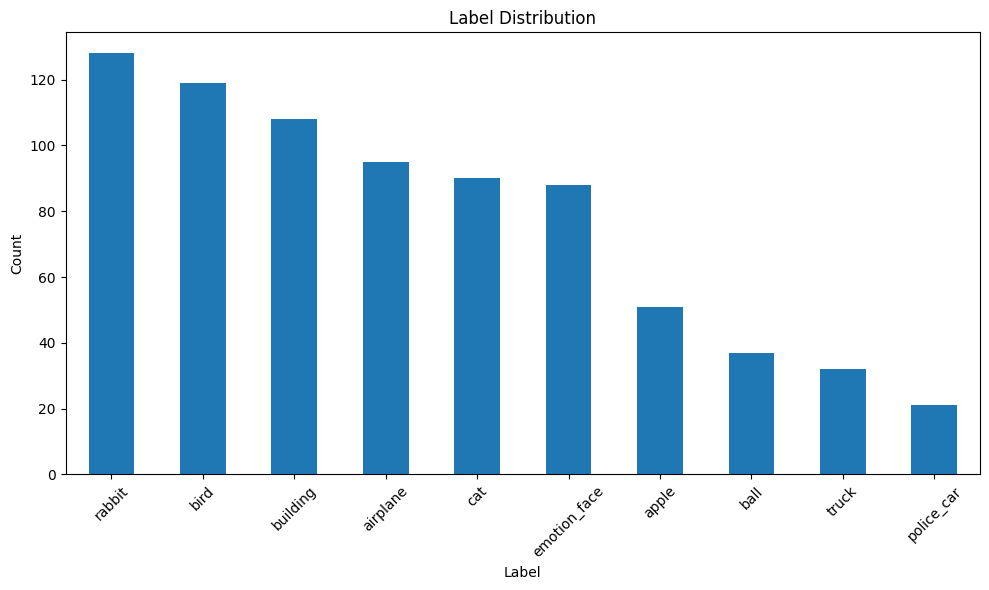

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv('/content/train.csv')

# label 분포 확인
label_counts = df['label'].value_counts()


label_distribution = label_counts.reset_index()
label_distribution.columns = ['label', 'count']
print(label_distribution)

# 시각화
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Config / Hyperparams

In [ ]:
N_EPOCHS = 100
BATCH_SIZE = 8
LR = 5e-5
N_FOLDS = 10
SEED = 42

# FocalLoss

FocalLoss란?
Object Detection에서 Background / Foreground Class의 불균형 문제를

loss 함수로 해결하기 위해 제안된 loss



이걸 클래스 분균형이 심한 일반 분류 문제에도

적용할 수 있다.



핵심 아이디어는 다음과 같다.

모델 입장에서 쉽다고 판단하는 example에 대해서

모델의 출력 확률(confidence) Pt가 높게 나올테니



(1-Pt)^gamma를 CE에 추가해줌으로써

높은 확신에 대해 패널티를 주는 방법



반대로 어려워하고 있는 example에 대해선

Pt가 낮게 나올테니 (1-Pt)^gamma가 상대적으로 높게 나올 것!



gamma가 높을 수록 (1-Pt)가 작을 수록 더 작아진다

(확신이 높은 example은 패널티를 더 받음)

 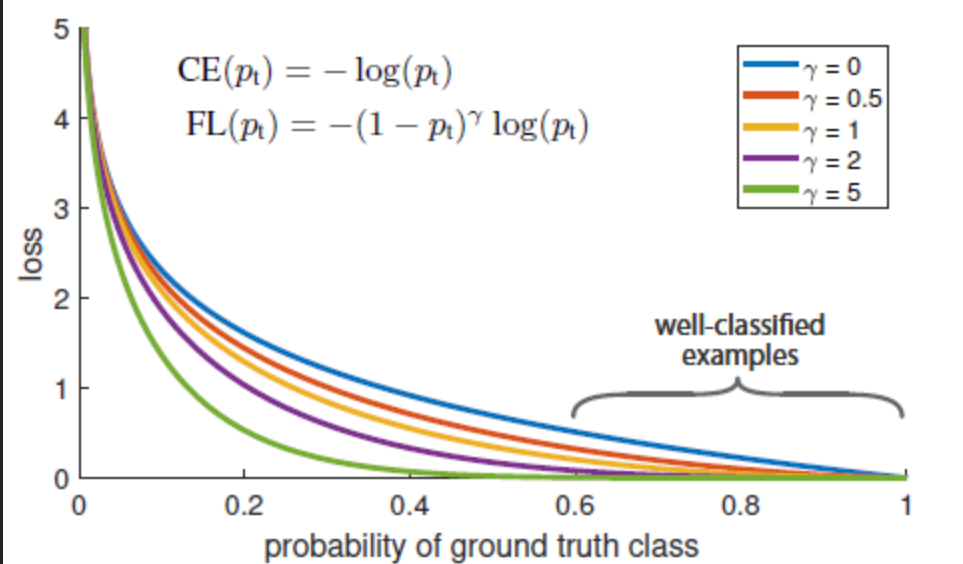



In [ ]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)  # Fix

        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduce:
            return focal_loss.mean()
        else:
            return focal_loss


# Data Loading

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

encoder = LabelEncoder()
train['label'] = encoder.fit_transform(train['label'])

label_counts = Counter(train['label'])
num_classes = len(label_counts)
total = sum(label_counts.values())

class_weights = [total / label_counts[i] for i in range(num_classes)]
class_weights = torch.FloatTensor(class_weights).to(device)

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for train_idx, valid_idx in skf.split(train.iloc[:, 2:], train['label']):
    break

# Datasets & DataLoaders

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, pixel_df, label_df=None, transform=None):
        self.pixel_df = pixel_df.reset_index(drop=True)
        self.label_df = label_df.reset_index(drop=True) if label_df is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.pixel_df)

    def __getitem__(self, idx):
        # Reshape to (32, 32) from flattened data
        image = self.pixel_df.iloc[idx].values.astype(np.uint8).reshape(32, 32)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # shape: (1, 32, 32)

        if self.transform:
            image = self.transform(image)

        if self.label_df is not None:
            label = torch.tensor(self.label_df.iloc[idx], dtype=torch.long)
            return image, label
        else:
            return image

train_transform = Compose([
    ToPILImage(),                            # Tensor → PIL 이미지로 변환
    Grayscale(num_output_channels=3),        # 1채널 이미지를 3채널로 복제
    RandomHorizontalFlip(p=0.5),             # 50% 확률로 좌우 반전
    RandomRotation(degrees=20),              # ±15도 내에서 랜덤 회전
    Resize((224, 224)),                      # 사이즈 조정
    ToTensor(),                              # PIL 이미지 → Tensor
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # 3채널용 정규화
])

test_transform = Compose([
    ToPILImage(),
    Grayscale(num_output_channels=3),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CustomDataset(pixel_df=train.iloc[train_idx, 2:], label_df=train.iloc[train_idx, 1], transform=train_transform)
valid_dataset = CustomDataset(pixel_df=train.iloc[valid_idx, 2:], label_df=train.iloc[valid_idx, 1], transform=train_transform)
test_dataset = CustomDataset(pixel_df=test.iloc[:, 1:], transform=train_transform)

loader_params = {
    'batch_size': BATCH_SIZE,
    'num_workers': 8,
    'pin_memory': True
}

train_loader = DataLoader(train_dataset, shuffle=True, **loader_params)
valid_loader = DataLoader(valid_dataset, shuffle=False, **loader_params)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_params)

# Model & Optim Setup

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=LR) # torch.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

AdamW란? Adam 옵티마이저의 변형으로, 가중치 감쇠(weight decay)를 적용하는 것이 특징입니다. 가중치 감쇠는 모델의 가중치를 감소시킴으로써 모델의 복잡성을 제어하고, 오버피팅(overfitting)을 완화하는 효과가 있습니다.

*   params: 최적화할 모델의 파라미터들
*   lr: 학습률(learning rate), 기본값은 0.001
*   betas: 감마 값들 (beta1, beta2)로 이루어진 튜플, 기본값은 (0.9, 0.999)
*   eps: 분모를 0으로 나누는 것을 방지하기 위한 작은 상수값, 기본값은 1e-08
*   betas: 감마 값들 (beta1, beta2)로 이루어진 튜플, 기본값은 (0.9, 0.999)
*   weight_decay: 가중치 감쇠(L2 정규화) 계수, 기본값은 0
*   amsgrad: AMSGrad 알고리즘을 사용할지 여부, 기본값은 False

In [ ]:
print(next(model.parameters()).device)

cuda:0


# Training Loop

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy

train_losses = []
val_losses = []
val_accuracies = []

best_loss = float('inf')
best_model = None

for epoch in range(N_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{N_EPOCHS}]")

    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate
    val_loss, val_acc = validate_one_epoch(model, valid_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc*100:.2f}%")

    # Check for best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model

    scheduler.step()


Epoch [1/100]


Train Loss: 0.3675 | Val Loss: 0.2834 | Val Accuracy: 40.26%

Epoch [2/100]


Train Loss: 0.2269 | Val Loss: 0.2266 | Val Accuracy: 49.35%

Epoch [3/100]


Train Loss: 0.1641 | Val Loss: 0.1552 | Val Accuracy: 63.64%

Epoch [4/100]


Train Loss: 0.1253 | Val Loss: 0.1245 | Val Accuracy: 66.23%

Epoch [5/100]


Train Loss: 0.1133 | Val Loss: 0.1239 | Val Accuracy: 68.83%

Epoch [6/100]


Train Loss: 0.0889 | Val Loss: 0.1285 | Val Accuracy: 66.23%

Epoch [7/100]


Train Loss: 0.0769 | Val Loss: 0.0858 | Val Accuracy: 77.92%

Epoch [8/100]


Train Loss: 0.0670 | Val Loss: 0.0688 | Val Accuracy: 80.52%

Epoch [9/100]


Train Loss: 0.0528 | Val Loss: 0.0632 | Val Accuracy: 84.42%

Epoch [10/100]


Train Loss: 0.0506 | Val Loss: 0.0473 | Val Accuracy: 87.01%

Epoch [11/100]


Train Loss: 0.0463 | Val Loss: 0.0735 | Val Accuracy: 85.71%

Epoch [12/100]


Train Loss: 0.0353 | Val Loss: 0.0433 | Val Accuracy: 87.01%

Epoch [13/100]


Train Loss: 0.0321 | Val Loss: 0.0790 | Val Accuracy: 81.82%

Epoch [14/100]


Train Loss: 0.0262 | Val Loss: 0.0442 | Val Accuracy: 85.71%

Epoch [15/100]


Train Loss: 0.0274 | Val Loss: 0.0396 | Val Accuracy: 92.21%

Epoch [16/100]


Train Loss: 0.0236 | Val Loss: 0.0414 | Val Accuracy: 83.12%

Epoch [17/100]


Train Loss: 0.0286 | Val Loss: 0.0311 | Val Accuracy: 90.91%

Epoch [18/100]


Train Loss: 0.0232 | Val Loss: 0.0351 | Val Accuracy: 94.81%

Epoch [19/100]


Train Loss: 0.0180 | Val Loss: 0.0740 | Val Accuracy: 79.22%

Epoch [20/100]


Train Loss: 0.0223 | Val Loss: 0.0334 | Val Accuracy: 88.31%

Epoch [21/100]


Train Loss: 0.0242 | Val Loss: 0.0357 | Val Accuracy: 88.31%

Epoch [22/100]


Train Loss: 0.0203 | Val Loss: 0.0299 | Val Accuracy: 89.61%

Epoch [23/100]


Train Loss: 0.0188 | Val Loss: 0.0230 | Val Accuracy: 94.81%

Epoch [24/100]


Train Loss: 0.0148 | Val Loss: 0.0446 | Val Accuracy: 89.61%

Epoch [25/100]


Train Loss: 0.0151 | Val Loss: 0.0526 | Val Accuracy: 89.61%

Epoch [26/100]


Train Loss: 0.0150 | Val Loss: 0.0272 | Val Accuracy: 92.21%

Epoch [27/100]


Train Loss: 0.0134 | Val Loss: 0.0227 | Val Accuracy: 89.61%

Epoch [28/100]


Train Loss: 0.0103 | Val Loss: 0.0166 | Val Accuracy: 93.51%

Epoch [29/100]


Train Loss: 0.0133 | Val Loss: 0.0506 | Val Accuracy: 85.71%

Epoch [30/100]


Train Loss: 0.0111 | Val Loss: 0.0318 | Val Accuracy: 93.51%

Epoch [31/100]


Train Loss: 0.0121 | Val Loss: 0.0338 | Val Accuracy: 89.61%

Epoch [32/100]


Train Loss: 0.0067 | Val Loss: 0.0179 | Val Accuracy: 97.40%

Epoch [33/100]


Train Loss: 0.0074 | Val Loss: 0.0316 | Val Accuracy: 90.91%

Epoch [34/100]


Train Loss: 0.0086 | Val Loss: 0.0247 | Val Accuracy: 88.31%

Epoch [35/100]


Train Loss: 0.0099 | Val Loss: 0.0348 | Val Accuracy: 89.61%

Epoch [36/100]


Train Loss: 0.0058 | Val Loss: 0.0287 | Val Accuracy: 89.61%

Epoch [37/100]


Train Loss: 0.0090 | Val Loss: 0.0243 | Val Accuracy: 94.81%

Epoch [38/100]


Train Loss: 0.0091 | Val Loss: 0.0224 | Val Accuracy: 94.81%

Epoch [39/100]


Train Loss: 0.0075 | Val Loss: 0.0198 | Val Accuracy: 97.40%

Epoch [40/100]


Train Loss: 0.0081 | Val Loss: 0.0296 | Val Accuracy: 88.31%

Epoch [41/100]


Train Loss: 0.0062 | Val Loss: 0.0290 | Val Accuracy: 90.91%

Epoch [42/100]


Train Loss: 0.0054 | Val Loss: 0.0334 | Val Accuracy: 92.21%

Epoch [43/100]


Train Loss: 0.0064 | Val Loss: 0.0405 | Val Accuracy: 88.31%

Epoch [44/100]


Train Loss: 0.0053 | Val Loss: 0.0227 | Val Accuracy: 89.61%

Epoch [45/100]


Train Loss: 0.0065 | Val Loss: 0.0285 | Val Accuracy: 90.91%

Epoch [46/100]


Train Loss: 0.0042 | Val Loss: 0.0313 | Val Accuracy: 93.51%

Epoch [47/100]


Train Loss: 0.0019 | Val Loss: 0.0238 | Val Accuracy: 93.51%

Epoch [48/100]


Train Loss: 0.0042 | Val Loss: 0.0209 | Val Accuracy: 96.10%

Epoch [49/100]


Train Loss: 0.0047 | Val Loss: 0.0387 | Val Accuracy: 92.21%

Epoch [50/100]


Train Loss: 0.0079 | Val Loss: 0.0242 | Val Accuracy: 92.21%

Epoch [51/100]


Train Loss: 0.0049 | Val Loss: 0.0245 | Val Accuracy: 94.81%

Epoch [52/100]


Train Loss: 0.0054 | Val Loss: 0.0224 | Val Accuracy: 93.51%

Epoch [53/100]


Train Loss: 0.0066 | Val Loss: 0.0205 | Val Accuracy: 92.21%

Epoch [54/100]


Train Loss: 0.0051 | Val Loss: 0.0225 | Val Accuracy: 94.81%

Epoch [55/100]


Train Loss: 0.0098 | Val Loss: 0.0303 | Val Accuracy: 92.21%

Epoch [56/100]


Train Loss: 0.0035 | Val Loss: 0.0267 | Val Accuracy: 92.21%

Epoch [57/100]


Train Loss: 0.0039 | Val Loss: 0.0312 | Val Accuracy: 90.91%

Epoch [58/100]


Train Loss: 0.0026 | Val Loss: 0.0201 | Val Accuracy: 94.81%

Epoch [59/100]


Train Loss: 0.0036 | Val Loss: 0.0197 | Val Accuracy: 94.81%

Epoch [60/100]


Train Loss: 0.0027 | Val Loss: 0.0278 | Val Accuracy: 94.81%

Epoch [61/100]


Train Loss: 0.0032 | Val Loss: 0.0205 | Val Accuracy: 94.81%

Epoch [62/100]


Train Loss: 0.0020 | Val Loss: 0.0232 | Val Accuracy: 93.51%

Epoch [63/100]


Train Loss: 0.0025 | Val Loss: 0.0214 | Val Accuracy: 94.81%

Epoch [64/100]


Train Loss: 0.0023 | Val Loss: 0.0191 | Val Accuracy: 97.40%

Epoch [65/100]


Train Loss: 0.0030 | Val Loss: 0.0289 | Val Accuracy: 96.10%

Epoch [66/100]


Train Loss: 0.0019 | Val Loss: 0.0155 | Val Accuracy: 94.81%

Epoch [67/100]


Train Loss: 0.0014 | Val Loss: 0.0202 | Val Accuracy: 97.40%

Epoch [68/100]


Train Loss: 0.0013 | Val Loss: 0.0110 | Val Accuracy: 97.40%

Epoch [69/100]


Train Loss: 0.0017 | Val Loss: 0.0097 | Val Accuracy: 98.70%

Epoch [70/100]


Train Loss: 0.0017 | Val Loss: 0.0151 | Val Accuracy: 97.40%

Epoch [71/100]


Train Loss: 0.0042 | Val Loss: 0.0181 | Val Accuracy: 96.10%

Epoch [72/100]


Train Loss: 0.0014 | Val Loss: 0.0196 | Val Accuracy: 94.81%

Epoch [73/100]


Train Loss: 0.0030 | Val Loss: 0.0202 | Val Accuracy: 94.81%

Epoch [74/100]


Train Loss: 0.0020 | Val Loss: 0.0108 | Val Accuracy: 96.10%

Epoch [75/100]


Train Loss: 0.0010 | Val Loss: 0.0177 | Val Accuracy: 96.10%

Epoch [76/100]


Train Loss: 0.0015 | Val Loss: 0.0140 | Val Accuracy: 97.40%

Epoch [77/100]


Train Loss: 0.0012 | Val Loss: 0.0124 | Val Accuracy: 94.81%

Epoch [78/100]


Train Loss: 0.0013 | Val Loss: 0.0192 | Val Accuracy: 97.40%

Epoch [79/100]


Train Loss: 0.0009 | Val Loss: 0.0059 | Val Accuracy: 100.00%

Epoch [80/100]


Train Loss: 0.0007 | Val Loss: 0.0125 | Val Accuracy: 97.40%

Epoch [81/100]


Train Loss: 0.0009 | Val Loss: 0.0131 | Val Accuracy: 96.10%

Epoch [82/100]


Train Loss: 0.0008 | Val Loss: 0.0141 | Val Accuracy: 97.40%

Epoch [83/100]


Train Loss: 0.0007 | Val Loss: 0.0080 | Val Accuracy: 98.70%

Epoch [84/100]


Train Loss: 0.0007 | Val Loss: 0.0119 | Val Accuracy: 97.40%

Epoch [85/100]


Train Loss: 0.0010 | Val Loss: 0.0111 | Val Accuracy: 97.40%

Epoch [86/100]


Train Loss: 0.0008 | Val Loss: 0.0144 | Val Accuracy: 94.81%

Epoch [87/100]


Train Loss: 0.0008 | Val Loss: 0.0126 | Val Accuracy: 98.70%

Epoch [88/100]


Train Loss: 0.0022 | Val Loss: 0.0120 | Val Accuracy: 97.40%

Epoch [89/100]


Train Loss: 0.0011 | Val Loss: 0.0117 | Val Accuracy: 96.10%

Epoch [90/100]


Train Loss: 0.0010 | Val Loss: 0.0136 | Val Accuracy: 94.81%

Epoch [91/100]


Train Loss: 0.0020 | Val Loss: 0.0129 | Val Accuracy: 97.40%

Epoch [92/100]


Train Loss: 0.0030 | Val Loss: 0.0196 | Val Accuracy: 96.10%

Epoch [93/100]


Train Loss: 0.0007 | Val Loss: 0.0115 | Val Accuracy: 97.40%

Epoch [94/100]


Train Loss: 0.0008 | Val Loss: 0.0118 | Val Accuracy: 97.40%

Epoch [95/100]


Train Loss: 0.0009 | Val Loss: 0.0090 | Val Accuracy: 98.70%

Epoch [96/100]


Train Loss: 0.0011 | Val Loss: 0.0114 | Val Accuracy: 98.70%

Epoch [97/100]


Train Loss: 0.0007 | Val Loss: 0.0165 | Val Accuracy: 96.10%

Epoch [98/100]


Train Loss: 0.0006 | Val Loss: 0.0117 | Val Accuracy: 98.70%

Epoch [99/100]


Train Loss: 0.0013 | Val Loss: 0.0147 | Val Accuracy: 96.10%

Epoch [100/100]


Train Loss: 0.0007 | Val Loss: 0.0135 | Val Accuracy: 97.40%


In [ ]:
print(criterion)

FocalLoss()


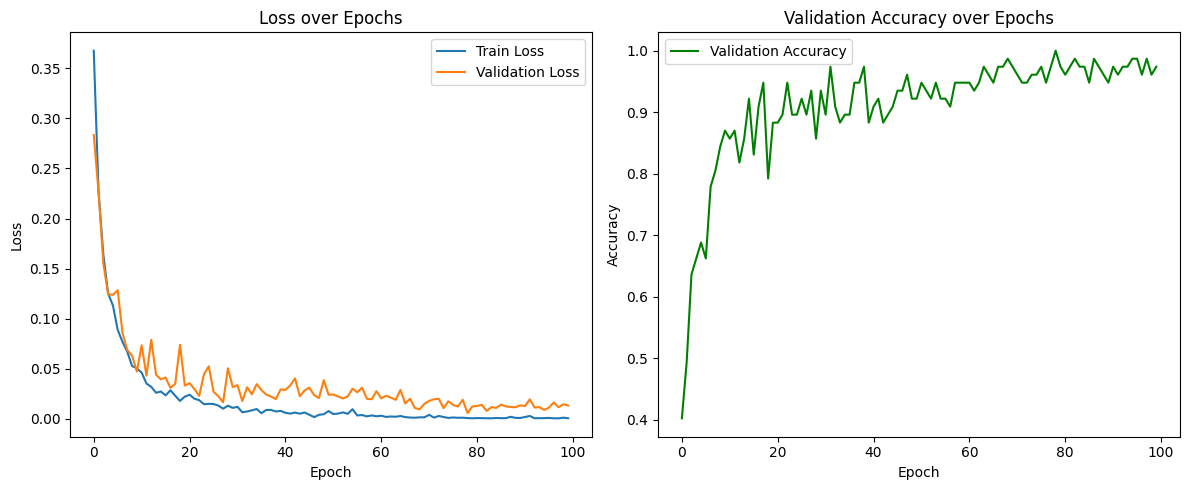

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# Inference

In [ ]:
best_model.eval()
preds = []

with torch.no_grad():
    for images in tqdm(test_loader, desc="Inference", leave=False):
        images = images.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())

# Decode predictions
pred_labels = encoder.inverse_transform(preds)

# Submission

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['label'] = pred_labels
submission.to_csv('baseline_submission.csv', index=False)

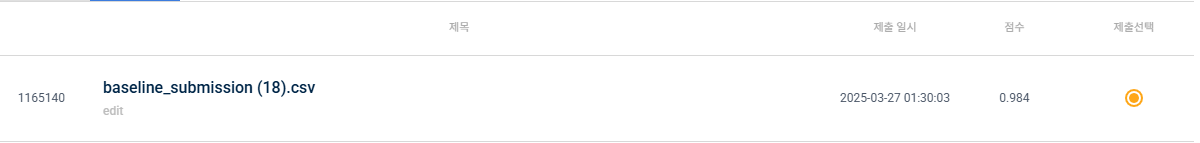